In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Importation des données

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

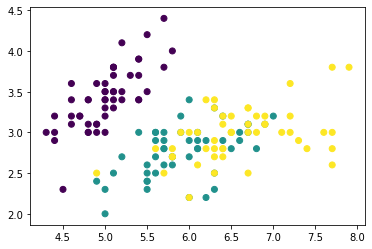

In [3]:
scatter(X[:, 0], X[:, 1], c = y)

Si on essaie de projeter nos données dans une base quelconque (ici la base formée par les deux premiers vecteurs) on remarque qu'on n'arrive pas à distinguer deux espèces car elles sont entremélées. L'idée est de trouver le meilleur plan de projection. 

La marche à suivre sera la suivante:
1. Trouver un point de ce plan (ce sera l'isobarycentre).
2. Trouver deux vecteurs: ce seront les vecteurs propres associées aux des plus grandes valeurs propres.
3. Projeter sur ce plan.

## Etape de centrage

In [4]:
Xe = mean(X, axis = 0)
n, p = shape(X)
for i in range(n):
    X[i, :] -= Xe

In [5]:
A = matmul(X.T, X)
tol = 10 ** (-10)

## Méthode de la puissance

In [6]:
def puissance(A, tol):
    x = rand(shape(A)[0], 1)
    x = x / norm(x)
    Ax = matmul(A, x)
    err = Ax - vdot(Ax, x) * x
    while norm(err) > tol :
        x = Ax / norm(Ax)
        Ax = matmul(A, x)
        err = Ax - vdot(Ax, x) * x
    return x, vdot(Ax, x)
        

## Méthode de la puissance itérée

In [7]:
def puissanceiteree(A, tol):
    n = len(A)
    u, l =  puissance(A, tol)
    vp = zeros(n)
    vp[0] = l
    vectp = zeros((n,n))
    vectp[:, 0] = u.reshape(n)
    for i in range(1, len(A)):
        A = A - l * matmul(u, u.T)
        u, l =  puissance(A, tol)
        vp[i] = l
        vectp[:, i] = u.reshape(n)
    return vp, vectp


In [8]:
vp, vectp = puissanceiteree(A, tol)

## Projection des résultats

In [9]:
P = zeros((2, shape(X)[0]))
for i in range(shape(X)[0]):
    P[0, i] = vdot(vectp[:, 0],  X[i, :])
    P[1, i] = vdot(vectp[:, 1],  X[i, :])

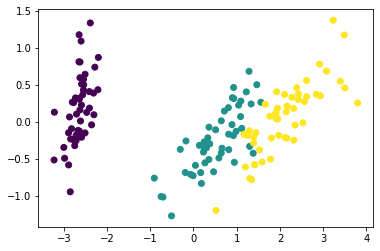

In [10]:
scatter(P[0, :], P[1, :], c = y)

## Méthode de Jacobi

In [11]:
def annul(i, j, A):
    n = len (A)
    G = eye(n)
    tau = (A[i, i] - A[j, j])/(2 * A[i, j])
    t = sign(tau)/(abs(tau) + sqrt(1 + tau ** 2))
    c = 1 / sqrt(1 + t ** 2)
    s = c * t
    G[i, i] = c
    G[j, j] = c
    G[i, j] = -s
    G[j, i] = s
    return G

In [12]:
def jacobi(A, tol):
    n = len(A)
    J = eye(n)
    while norm(A - diag(diag(A))) > tol:
        i, j = unravel_index(argmax(abs(A - diag(diag(A)))), A.shape)
        G = annul(i, j, A)
        A = matmul(matmul(G.T, A), G)
        J = matmul(J, G)
    return diag(A), J

In [13]:
jacobi(A, tol)

(array([ 11.65321551,  36.15794144, 630.0080142 ,   3.55142885]),
 array([[ 0.58202985,  0.65658877,  0.36138659,  0.31548719],
        [-0.59791083,  0.73016143, -0.08452251, -0.3197231 ],
        [-0.07623608, -0.17337266,  0.85667061, -0.47983899],
        [-0.54583143, -0.07548102,  0.3582892 ,  0.75365743]]))

## Comparaison des méthodes

In [14]:
ntot = 7
n = [2 ** i for i in range(1, ntot + 1)]
mpi = []
errpi = []
errj = []
for i in range(ntot):
    A = rand(n[i], n[i])
    A = matmul(A.T, A)
    a = sort(eig(A)[0])
    b = puissanceiteree(A, tol)[0]
    errpi.append(norm(sort(b) - a))
    c = jacobi(A, tol)[0]
    errj.append(norm(sort(c) - a))

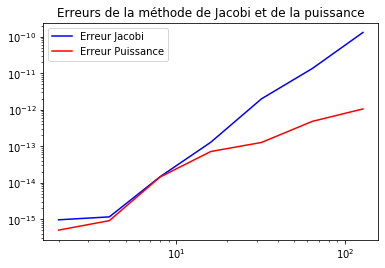

In [15]:
p1=loglog(n, errj, 'b', label = "Erreur Jacobi")
p2=loglog(n, errpi, 'r', label = "Erreur Puissance")
title("Erreurs de la méthode de Jacobi et de la puissance")  
legend(loc = 'upper left')
show()